In [2]:
import numpy as np
import copy

In [22]:
KEY_TIE = 'tie'
KEY_ONGOING = 'ongoing'
KEY_WON_P1 = 'won_p1'
KEY_WON_P2 = 'won_p2'
KEY_P1 = 1
KEY_P2 = 2

n_games = 50000

alpha = 0.1
gamma = 1
init_epsilon = 1.0

start_decay = 1000
e_decay = 0.99

win_reward = 1
lose_reward = -1
tie_reward = 0

In [4]:
def get_board_string(board):
    return str(copy.copy(board).reshape(9))

In [5]:
def get_q_values(_q_table, state, set_nan=True):

    next_board_string = get_board_string(state)

    if _q_table.get(next_board_string) is None:
        q_values = np.zeros([3,3]) 

        if set_nan:
            it = np.nditer(state, flags=['multi_index'])
            for x in it:
                if x != 0:
                    q_values[it.multi_index] = np.nan
    else:
        q_values = _q_table.get(next_board_string)

    return q_values

In [6]:
test_state_1 = np.array([[1,2,0],[0,0,2],[0,0,1]])
test_state_2 = np.array([[1,2,2],[1,1,2],[0,1,1]])

s_b = get_board_string(test_state_1)
test_q_table = {}
test_q_table[s_b] = np.array([[np.nan,np.nan,1],[1,1,np.nan],[0,2,np.nan]])

get_q_values(test_q_table, test_state_2)

array([[nan, nan, nan],
       [nan, nan, nan],
       [ 0., nan, nan]])

In [7]:
def update_state(state, _q_table, epsilon, player_id):

    q_values = get_q_values(_q_table, state)
    
    r = np.random.rand()
    
    if np.all(np.isnan(q_values)) and not np.count_nonzero(state==0) == 0:
        print('ERROR: q values all zero but still a free spot')

    if np.all(np.isnan(q_values)):
        return state

    if r < (1-epsilon):
        # find max of q table
        action_idxs = np.where(q_values == np.nanmax(q_values))
        ran_a_idx = np.random.randint(len(action_idxs[0]))
        action_idx = (action_idxs[0][ran_a_idx], action_idxs[1][ran_a_idx])
    else:
        non_nan_idxs = np.argwhere(~np.isnan(q_values))
        r_idx = np.random.randint(non_nan_idxs.shape[0])
        action_idx = non_nan_idxs[r_idx,:]

    new_state = copy.copy(state)
    new_state[action_idx[0], action_idx[1]] = player_id

    return new_state, action_idx

In [8]:
update_state(test_state_1, test_q_table, 0, 1)

(array([[1, 2, 0],
        [0, 0, 2],
        [0, 1, 1]]),
 (2, 1))

In [9]:
def update_q_table(q_table, action_idx, current_board, next_board, reward):

    board_string = get_board_string(current_board)
    curr_q_values = get_q_values(q_table, current_board)
    
    next_q_values = get_q_values(q_table, next_board)

    max_q_values = np.nanmax(next_q_values)
    if np.isnan(max_q_values):
        max_q_values = 0

    curr_q_values[action_idx] += alpha*(reward + gamma * max_q_values - curr_q_values[action_idx])

    q_table[board_string] = curr_q_values

    return q_table

In [10]:
test_q_table = {'[1 2 2 1 0 0 1 0 0]': [[np.nan,  np.nan, np.nan],
        [np.nan, 1,  1.],
        [np.nan, 1, 1]],
        '[1 0 2 1 0 0 0 0 0]': np.array([[np.nan, 0. , np.nan],
        [np.nan, 0.2, 0. ],
        [0. , 0. , 0. ]])}

current_board = np.array([[1,0,2],[1, 0, 0],[0,0,0]])
next_board = np.array([[1,2,2],[1, 0, 0],[1,0,0]])

update_q_table(test_q_table, (1,1), current_board, next_board, 1)


{'[1 2 2 1 0 0 1 0 0]': [[nan, nan, nan], [nan, 1, 1.0], [nan, 1, 1]],
 '[1 0 2 1 0 0 0 0 0]': array([[ nan, 0.  ,  nan],
        [ nan, 0.38, 0.  ],
        [0.  , 0.  , 0.  ]])}

In [11]:
def game_status(state):
    
    # check if someone has won
    possible_winning_comb = np.zeros((8, 3))
    possible_winning_comb[:3,:] = state
    possible_winning_comb[3:6,:] = state.T
    possible_winning_comb[6,:] = state.diagonal()
    possible_winning_comb[7,:] = np.fliplr(state).diagonal()
    
    for row in possible_winning_comb:
        if np.all(row == KEY_P1):
            return KEY_WON_P1
        elif np.all(row == KEY_P2):
            return KEY_WON_P2

    # check if tie
    if np.count_nonzero(state==0) == 0:
        return KEY_TIE

    return KEY_ONGOING

In [12]:
test_state_3 = np.array([[1,2,1],[1,1,2],[2,1,2]])
test_state_4 = np.array([[2., 0., 0.], [0., 1., 0.,], [0., 1., 2.]])
game_status(test_state_4)

'ongoing'

In [25]:
q_table1 = {}     
q_table2 = {}

results = []

epsilon = init_epsilon

res_p1 = []
res_p2 = []
res_tie = []

rp1 = 0
rp2 = 0
rtie = 0

no_reward = 0

for i in range(n_games):

    if i % 250 == 0 and i != 0:
        res_p1.append(rp1)
        res_p2.append(rp2)
        res_tie.append(rtie)
        rp1 = 0
        rp2 = 0
        rtie = 0

    if i % 5000 == 0:
        print('game ', i)

    if i > start_decay:
        if i % 50 == 0:
            epsilon *= e_decay

    # init board
    result = None
    board = np.zeros([3,3])
    last_board1 = np.zeros([3,3])
    last_board2 = np.zeros([3,3])

    _status = KEY_ONGOING

    # player 1 moves
    last_board1 = board
    board, action1 = update_state(board, q_table1, epsilon, KEY_P1)
    
    # player 2 moves
    last_board2 = board
    board, action2 = update_state(board, q_table2, epsilon, KEY_P2)

    # update q1
    q_table1 = update_q_table(q_table1, action1, last_board1, board, no_reward)

    while _status == KEY_ONGOING:
        # player 1 move 
        last_board1 = board
        board, action1 = update_state(board, q_table1, epsilon, KEY_P1)

        _status = game_status(board)
        if _status != KEY_ONGOING:
            result = _status
            break
        else:
            # update Q2
            q_table2 = update_q_table(q_table2, action2, last_board2, board, no_reward)

        # player 2 move 
        last_board2 = board
        board, action2 = update_state(board, q_table2, epsilon, KEY_P2)

        _status = game_status(board)
        if _status != KEY_ONGOING:
            result = _status
            break
        else:
            # update Q1
            q_table1 = update_q_table(q_table1, action1, last_board1, board, no_reward)

    # update q1 and q2 with corresponding reward
    if _status == KEY_WON_P1:
        q_table1 = update_q_table(q_table1, action1, last_board1, board, win_reward)
        q_table2 = update_q_table(q_table2, action2, last_board2, board, lose_reward)
        rp1 += 1
    elif _status == KEY_WON_P2:
        q_table1 = update_q_table(q_table1, action1, last_board1, board, lose_reward)
        q_table2 = update_q_table(q_table2, action2, last_board2, board, win_reward)
        rp2 += 1
    elif _status == KEY_TIE:       
        q_table1 = update_q_table(q_table1, action1, last_board1, board, tie_reward)
        q_table2 = update_q_table(q_table2, action2, last_board2, board, tie_reward)
        rtie += 1
    else:
        print('ERROR: unexpected result')

    results.append(_status)

print('done')

game  0


<ipython-input-9-89da29e15b00>:8: RuntimeWarning: All-NaN slice encountered
  max_q_values = np.nanmax(next_q_values)


game  5000
game  10000
game  15000
game  20000
game  25000
game  30000
game  35000
game  40000
game  45000
done


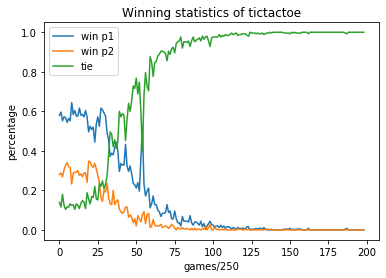

In [29]:
from matplotlib import pyplot as plt 

intvl = 250
pres_p1 = [x / intvl for x in res_p1]
pres_p2 = [x / intvl for x in res_p2]
pres_tie = [x / intvl for x in res_tie]

plt.plot(range(len(pres_p1)), pres_p1, label='win p1')
plt.plot(range(len(pres_p2)), pres_p2, label='win p2')
plt.plot(range(len(pres_tie)), pres_tie, label='tie')
plt.legend(loc="upper left")
plt.xlabel("games/250")
plt.ylabel("percentage")
plt.title("Winning statistics of tictactoe")
plt.savefig('ql_plot.png', format='png', dpi=1200)

In [27]:
import re

vals1 = np.array(list(q_table1.values()))
__q_values1 = np.concatenate(vals1, axis=1)

boards1 = []
for key in q_table1.keys():
    ints1 = np.array([int(s) for s in re.findall(r'\b\d+\b', key)]).reshape([3,3])
    boards1.append(ints1)

__boards1 = np.concatenate(boards1, axis=1)

__final1 = np.concatenate((__boards1, __q_values1), axis=0)
np.savetxt("player1.csv", __final1, delimiter=",")

In [28]:
import re

vals2 = np.array(list(q_table2.values()))
__q_values2 = np.concatenate(vals2, axis=1)

boards2 = []
for key in q_table2.keys():
    ints2 = np.array([int(s) for s in re.findall(r'\b\d+\b', key)]).reshape([3,3])
    boards2.append(ints2)

__boards2 = np.concatenate(boards2, axis=1)

__final2 = np.concatenate((__boards2, __q_values2), axis=0)
np.savetxt("player2.csv", __final2, delimiter=",")